In [8]:
pip install praw

  Using cached praw-7.8.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached prawcore-2.4.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached update_checker-0.18.0-py3-none-any.whl.metadata (2.3 kB)
Using cached praw-7.8.1-py3-none-any.whl (189 kB)
Using cached prawcore-2.4.0-py3-none-any.whl (17 kB)
Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)

   -------------------------- ------------- 2/3 [praw]
   ---------------------------------------- 3/3 [praw]

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
#from bot_detection.exploration.botDetector import generate_bot_score

In [125]:
bots = pd.read_csv('botbouncer_ground_truth.csv')

In [126]:
bots

,username,bot,status
0,harv318,True,banned
1,InitialTension8916,True,banned
2,filkbcwa,True,banned
3,Simsim123454321,True,banned
4,goyongj,True,banned
...,...,...,...
926,Quantum_Pineapple,False,declined
927,Big_Dick_NRG,False,declined
928,Lancearon,False,declined
929,spookyspritebottle,False,declined


In [124]:
len(bots[bots['bot']])/len(bots)

0.5048335123523093

In [128]:
len(bots[~bots['bot']])/len(bots)

0.49516648764769067

In [76]:
bots_test = pd.concat([bots[~bots['bot']].sample(100).copy(),bots[bots['bot']].sample(100).copy()])

In [11]:
bots_test['score'] = bots_test['username'].apply(generate_bot_score)

C:\Users\wkmp2\AppData\Local\Temp\ipykernel_28708\2417116360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bots_test['score'] = bots_test['username'].apply(generate_bot_score)


In [12]:
bots_test = bots_test.dropna()

In [53]:
bots[~bots['bot']]

,username,bot,status
183,Normal_Ad_6645,False,declined
185,BunsMcNuggets,False,declined
186,Later_Doober,False,declined
187,nefaariowarbear,False,declined
188,TwoIdleHands,False,declined
...,...,...,...
925,CatLightyear,False,declined
926,Quantum_Pineapple,False,declined
927,Big_Dick_NRG,False,declined
928,Lancearon,False,declined


In [81]:
import praw
from dotenv import load_dotenv
import os
import numpy as np
import time
from datetime import datetime
from collections import Counter
import math

load_dotenv()

# --- Reddit API setup ---
reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent="bot detection unwrapathon"
)

from prawcore.exceptions import NotFound, Forbidden, PrawcoreException

def fetch_user_data_safe(username, limit=50):
    try:
        user = reddit.redditor(username)

        # If user doesn't exist or is suspended, they won't have created_utc
        if not hasattr(user, "created_utc"):
            print(f"⚠️ Skipping user '{username}' (no created_utc — likely suspended or deleted)")
            return None

        created = user.created_utc
        user_data = {
            "username": username,
            "created_utc": created,
            "posts": [],
            "comments": []
        }

        # Try fetching recent posts and comments safely
        try:
            for post in user.submissions.new(limit=limit):
                user_data["posts"].append(post)
        except Exception as e:
            print(f"Post fetch error for {username}: {e}")

        try:
            for comment in user.comments.new(limit=limit):
                user_data["comments"].append(comment)
        except Exception as e:
            print(f"Comment fetch error for {username}: {e}")

        return user_data

    except Exception as e:
        print(f"Error fetching user {username}: {e}")
        return None

from collections import Counter
import re
from difflib import SequenceMatcher

import re


def compute_features_natural(user_data):
    """Compute raw heuristic features for bot likelihood."""
    now = time.time()
    age_days = (now - user_data["created_utc"]) / (60 * 60 * 24)
    posts = user_data["posts"]
    comments = user_data["comments"]

    # --- 1. Account age (in days) ---
    age = age_days

    # --- 2. Comment-to-post ratio ---
    total_posts = max(len(posts), 1)
    total_comments = len(comments)
    comment_to_post_ratio = total_comments / total_posts

    # --- 3. Subreddit diversity (number of unique subreddits) ---
    subreddits = (
        [p.subreddit.display_name for p in posts] +
        [c.subreddit.display_name for c in comments]
    )
    subreddit_diversity = len(set(subreddits))

    # --- 4. Activity spikes (boolean: 1 = spike detected, 0 = none) ---
    times = sorted([x.created_utc for x in posts + comments])
    activity_spike = 0
    if len(times) > 5:
        deltas = np.diff(times)
        mean_gap = np.mean(deltas)
        if np.any((deltas[:-1] > mean_gap * 5) & (deltas[1:] < mean_gap / 5)):
            activity_spike = 1

    # --- 5. Post-to-karma ratio ---
    # If available, try to fetch karma dynamically
    total_karma = 0
    try:
        user = reddit.redditor(user_data["username"])
        total_karma = user.link_karma + user.comment_karma
    except Exception:
        total_karma = 0

    post_to_karma_ratio = total_posts / max(total_karma, 1)

    # --- 7. Posts per day (raw count per day) ---
    posts_per_day = (len(posts) + len(comments)) / max(age_days, 1)

    return {
        "age_days": age,
        "total_posts": total_posts,
        "total_comments": total_comments,
        "comment_to_post_ratio": comment_to_post_ratio,
        "subreddit_diversity": subreddit_diversity,
        "activity_spike": activity_spike,
        "post_to_karma_ratio": post_to_karma_ratio,
        "duplicate_content_ratio": duplicate_content_ratio,
        "posts_per_day": posts_per_day,
    }


In [93]:
def analyze_user(username):
    data = fetch_user_data_safe(username)
    if data is None:
        return None
    try:
        return compute_features_natural(data)
    except Exception as e:
        print(f"Error for {username}: {e}")
        return None

In [123]:
results = []

n = 0

# Loop through each username
for username in bots_test['username'].unique():
    print(username)

    # Get the bot label for this username
    bot_label = bots_test.loc[bots_test['username'] == username, 'bot'].iloc[0]

    usr_feats = analyze_user(username)
    
    if usr_feats is not None:
    
        # Add username and label to the dict
        usr_feats['username'] = username
        usr_feats['bot'] = bot_label
    
        # Append to results list
        results.append(usr_feats)

    #if n % 10 == 0:
        #print(n)

    n += 1

# Convert all results into a DataFrame
bot_features = pd.DataFrame(results)

# Show a preview
print("Created feature table with shape:", bot_features.shape)
display(bot_features.head())

KeyGlum6538
IndependentThink4698
GoatDifferent1294
fatmanstan123
Key_Departure187
Famous-Example-8332
No-Willingness-170
Lopsided-Head-5143
GlumAppearance106
Lordnoallah
MacDynamite71
Human-Sheepherder797
sweetheart4012
Horror_Salt1523
PatentedPotato
ThatUsernameIsTaekin
PsychologicalRace739
Feisty-Tooth-7397
Nemisis_007
TwoIdleHands
FrankLangellasBalls
InternSignificant26
Specialist_Most_7338
HeraldofCool
DearDeerDoe
Mr-Big-Nicky-P
Adventurous_Pay_5827
Upset-Waltz-8952
dribblychops
cellphone_blanket
ballplayer5
SpotCreepy4570
External_Demand_8839
Davngr
unicornative
Passed1stGrade
PokeyPete
greengo07
PositronicShishkabob
Specialist-Essay-726
ConfidenceAgitated16
StrangeContest4
Researcher-52
Remarkable-Ad2285
MoreRamenPls
MobileCreepy7213
AmputeeHandModel
Novel-Truth-6468
DarmokBuiscuits
No_Street8874
X-calibreX
WeAreSolarAF
Extreme_Today_984
StarFighter6464
dragcuda74
ImRonniemundt
spawl123
SavageCucmber
Hot_Equivalent6562
watchwatertilitboils
freddbare
DudeYumi
Othercheek293Sugie
Em

,age_days,total_posts,total_comments,comment_to_post_ratio,subreddit_diversity,activity_spike,post_to_karma_ratio,duplicate_content_ratio,posts_per_day,username,bot
0,79.967483,1,0,0.000000,0,0,0.000202,0.0,0.000000,KeyGlum6538,False
1,134.035095,1,0,0.000000,0,0,0.000362,0.0,0.000000,IndependentThink4698,False
2,670.007256,3,100,33.333333,54,1,0.000239,0.0,0.153730,GoatDifferent1294,False
3,814.254543,17,100,5.882353,55,0,0.000586,0.0,0.143690,fatmanstan123,False
4,677.703035,1,100,100.000000,37,1,0.000324,0.0,0.147557,Key_Departure187,False


In [104]:
bot_features.to_csv('bot_features.csv', index=False)

In [83]:
# Apply the function and expand the dictionaries into columns
scores_df = bots_test['username'].apply(analyze_user).apply(pd.Series)

# Combine with the original DataFrame
bot_features = pd.concat([bots_test, scores_df], axis=1)

print(bots_test)

Error fetching user zonpldzc: received 404 HTTP response
Error fetching user Asianry: received 404 HTTP response
⚠️ Skipping user 'Illustrious-Yak3404' (no created_utc — likely suspended or deleted)
Error fetching user Business-Mulberry790: received 404 HTTP response
Error fetching user mekfappg: received 404 HTTP response
                 username    bot    status
897           KeyGlum6538  False  declined
484  IndependentThink4698  False  declined
724     GoatDifferent1294  False  declined
485         fatmanstan123  False  declined
341      Key_Departure187  False  declined
..                    ...    ...       ...
198     Nice-Decision5024   True    banned
170         TapLittle7779   True    banned
763            alexis3024   True    banned
673              lea_dvny   True    banned
336  BlueberriesCraveIron   True    banned

[200 rows x 3 columns]


In [129]:
bot_features = pd.read_csv('bot_training.csv')

In [130]:
from sklearn.model_selection import train_test_split

# Assume your DataFrame is df
# Features = all columns except 'bot'
X = bot_features.drop(columns=["bot"]).dropna()
y = bot_features.dropna()["bot"]

# Train/test split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=56, stratify=y
)

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (705, 9)
Test features shape: (177, 9)


In [131]:
X_train

,age_days,total_posts,total_comments,comment_to_post_ratio,subreddit_diversity,activity_spike,post_to_karma_ratio,posts_per_day,username
805,1052.376064,2,50,25.000000,27,1,0.000050,0.049412,BedRevolutionary8584
393,4107.798908,39,50,1.282051,44,1,0.000199,0.021666,Niarbeht
273,3007.637444,3,0,0.000000,3,0,0.250000,0.000997,MissHollyweed
302,635.372007,8,50,6.250000,26,0,0.004171,0.091285,Normal_Ad_6645
218,1495.701534,15,50,3.333333,2,1,0.098039,0.043458,No-Jackfruit8230
...,...,...,...,...,...,...,...,...,...
133,0.166641,1,0,0.000000,1,0,1.000000,1.000000,LargeSkirt8911
857,1185.814839,1,0,0.000000,0,0,0.000034,0.000000,Cubensio
562,166.746840,1,0,0.000000,1,0,0.004167,0.005997,Embarrassed_Reply324
352,746.965459,15,50,3.333333,42,0,0.008696,0.087019,Sad_Security_2550


In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Keep only numeric columns
numeric_cols = X_train.select_dtypes(include=["number"]).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# KNN with cosine distance
knn_cosine_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("knn", KNeighborsClassifier(n_neighbors=5, metric="cosine"))
])

# Fit the model
knn_cosine_pipeline.fit(X_train_numeric, y_train)

# Predict
y_pred_proba = knn_cosine_pipeline.predict_proba(X_test_numeric)
threshold = 0.7  # stricter: must be at least 70% confident it's a bot
y_pred_custom = (bot_prob >= threshold)                                               
bot_prob = y_pred_proba[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))
print(len(y_test))


Accuracy: 0.8135593220338984
              precision    recall  f1-score   support

       False       0.70      0.99      0.82        74
        True       0.99      0.69      0.81       103

    accuracy                           0.81       177
   macro avg       0.84      0.84      0.81       177
weighted avg       0.86      0.81      0.81       177

177


In [66]:
X_train_numeric.columns

Index(['age_days', 'total_posts', 'total _omments', 'comment_to_post_ratio',
       'subreddit_diversity', 'activity_spike', 'post_to_karma_ratio',
       'duplicate_content_ratio', 'posts_per_day'],
      dtype='object')

In [47]:
bots_test

,username,bot,status,score
751,shutterbug1961,False,declined,0.137095
703,Suspicious_Line_2910,False,declined,0.237500
598,Ill_Manufacturer1590,False,declined,0.237379
924,gassyhalibut,False,declined,0.137033
297,xrayrob2022,False,declined,0.237353
721,MONSTERBEARMAN,False,declined,0.137500
552,Scorpion2k4u,False,declined,0.137499
444,suddenlynotbanned,False,declined,0.236935
492,ErasmosOrolo,False,declined,0.137495
615,Massive_Reaction8845,False,declined,0.237500


In [116]:
y_pred_proba

array([[1. , 0. ],
       [1. , 0. ],
       [0.2, 0.8],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0.6, 0.4],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0.2, 0.8],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.2, 0.8],
       [1. , 0. ],
       [1. , 0. ],
       [0.4, 0.6],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.6, 0.4]])

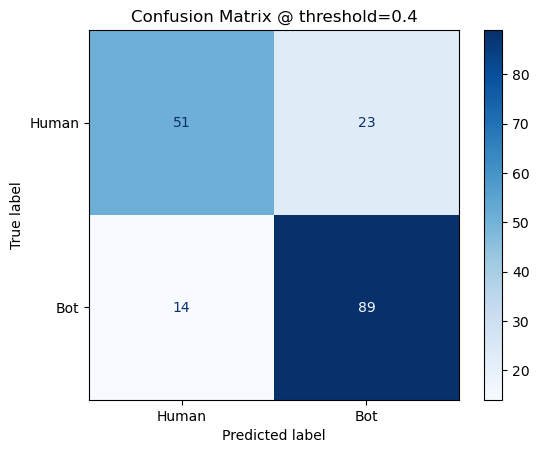

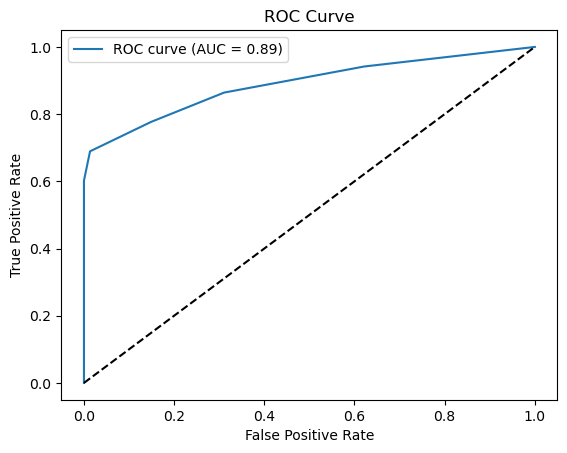

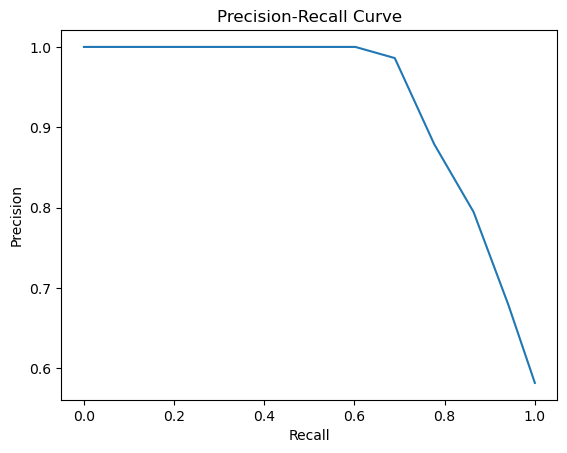

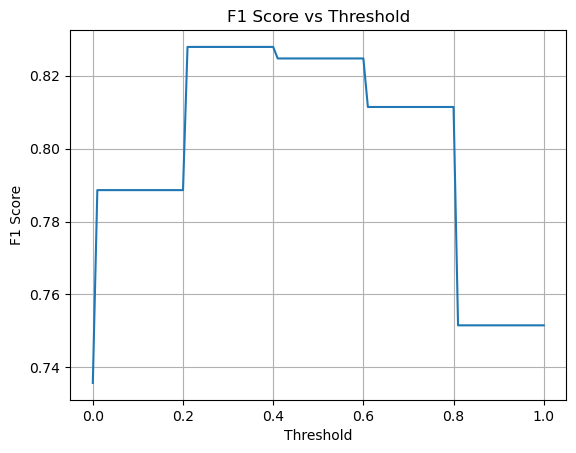

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    f1_score
)
import numpy as np

# Assume your DataFrame is called bots_df
y_true = y_test # Ground truth (1=bot, 0=human)
y_scores = y_pred_proba[:, 1]          # Predicted bot score

# ------------------------------
# Confusion matrix at default threshold (0.5)
# ------------------------------
threshold = 0.4
y_pred = (y_scores >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Human', 'Bot'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix @ threshold={threshold}')
plt.show()

# ------------------------------
# ROC Curve
# ------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ------------------------------
# Precision-Recall Curve
# ------------------------------
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ------------------------------
# F1 vs Threshold Curve
# ------------------------------
f1_scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    preds = (y_scores >= t).astype(int)
    f1_scores.append(f1_score(y_true, preds))

plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()


In [121]:
y_test

14     False
43     False
34     False
11     False
87     False
10     False
172     True
152     True
127     True
55     False
90     False
131     True
115     True
33     False
31     False
28     False
132     True
66     False
57     False
156     True
147     True
24     False
64     False
129     True
126     True
15     False
165     True
136     True
134     True
12     False
151     True
22     False
85     False
119     True
124     True
80     False
154     True
133     True
137     True
Name: bot, dtype: bool

## Random Forest Regressor

In [4]:
bot_features = pd.read_csv('bot_training.csv')

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Keep only numeric columns
numeric_cols = X_train.select_dtypes(include=["number"]).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# Random Forest pipeline
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # scaling not strictly necessary for RF, but harmless
    ("rf", RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        random_state=56,
        n_jobs=-1
    ))
])

# Fit model
rf_pipeline.fit(X_train_numeric, y_train)

# Predict probabilities
y_pred_proba = rf_pipeline.predict_proba(X_test_numeric)
bot_prob = y_pred_proba[:, 1]  # probability of "bot" class (assumed label = 1)

# Apply custom threshold
threshold = 0.7  # stricter threshold
y_pred_custom = (bot_prob >= threshold).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))
print("Number of test samples:", len(y_test))


Accuracy: 0.8983050847457628
              precision    recall  f1-score   support

       False       0.83      0.96      0.89        74
        True       0.97      0.85      0.91       103

    accuracy                           0.90       177
   macro avg       0.90      0.91      0.90       177
weighted avg       0.91      0.90      0.90       177

Number of test samples: 177


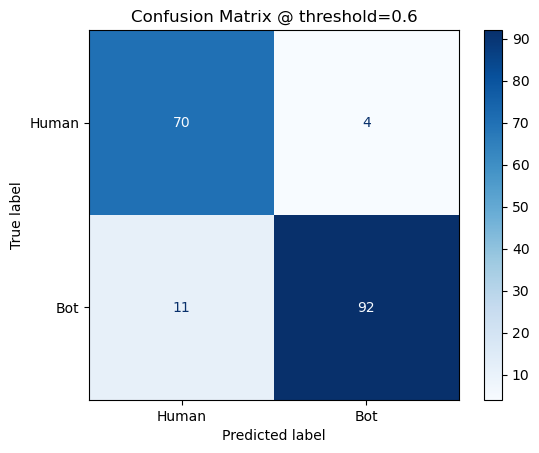

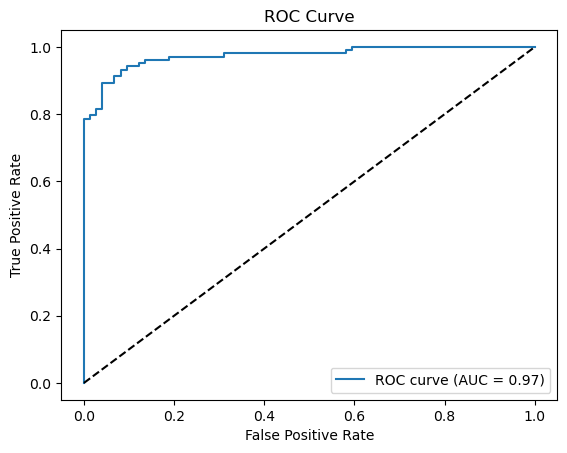

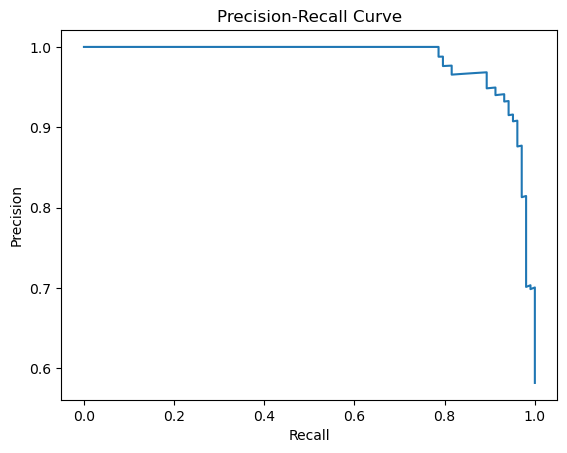

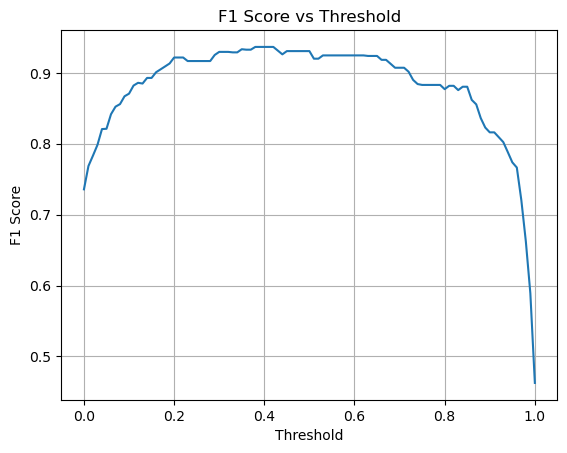

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    f1_score
)
import numpy as np

# Assume your DataFrame is called bots_df
y_true = y_test # Ground truth (1=bot, 0=human)
y_scores = y_pred_proba[:, 1]          # Predicted bot score

# ------------------------------
# Confusion matrix at default threshold (0.5)
# ------------------------------
threshold = 0.6
y_pred = (y_scores >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Human', 'Bot'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix @ threshold={threshold}')
plt.show()

# ------------------------------
# ROC Curve
# ------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ------------------------------
# Precision-Recall Curve
# ------------------------------
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ------------------------------
# F1 vs Threshold Curve
# ------------------------------
f1_scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    preds = (y_scores >= t).astype(int)
    f1_scores.append(f1_score(y_true, preds))

plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()


In [140]:
import joblib
joblib.dump(rf_pipeline, "bot_detector2.pkl")

['bot_detector.pkl']

In [141]:
# Later
rf_pipeline = joblib.load("bot_detector.pkl")

In [10]:
users = pd.read_parquet('../users.parquet', engine="fastparquet")

In [11]:
users

,username,age_days,total_posts,total_comments,comment_to_post_ratio,subreddit_diversity,activity_spike,post_to_karma_ratio,posts_per_day


In [12]:
user_scores = pd.read_parquet('../user_scores.parquet', engine="fastparquet")

In [13]:
user_scores

,username,score
